### Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import os
import pickle

# for clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# for map with HRU boundaries and budyko plot
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go

In [3]:
# table plotting style settings and functions

cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]}

def highlight_max(x):
    return ['background-color: #e6ffe6' if v == x.max() else '' for v in x]
def highlight_min(x):
    return ['background-color: #ffe6e6 ' if v == x.min() else '' for v in x]

### Loading hydrological signature, CAMELS attributes and scaling
1. list of catchments
2. hydrologcial signatures (CAMELS US dataset)
3. HRU number (CAMELS US dataset)
4. attributes (CAMELS US dataset)
5. scaling of attributes (-mean / std)

In [4]:
# 1. List of 516 CAMELS US catchments (with hourly Qobs available)
with open('data/516_basins.txt', 'r') as f:
    basin_list = [line.rstrip() for line in f]
    f.close()
# basin_list

In [5]:
# 2. Load hydrological signatures from Camels US dataset (for Budyko plot)
hydrol_attrib = pd.read_csv('data/camels_attributes/camels_hydro.txt', sep=';', dtype={'gauge_id': str})
hydrol_attrib.index = hydrol_attrib.gauge_id
hydrol_attrib = hydrol_attrib.drop('gauge_id', axis=1)
hydrol_attrib = hydrol_attrib.loc[hydrol_attrib.index.isin(basin_list)]
# hydrol_attrib

In [36]:
# 3. Load HRU associated with each catchment
huc_df = pd.read_csv('data/camels_attributes/camels_name.txt', header=0, dtype={'gauge_id': str, 'huc_02': str}, sep=';')
huc_df.index = huc_df.gauge_id
huc_df = huc_df.drop(columns='gauge_id')
huc_df = huc_df.loc[huc_df.index.isin(basin_list)]
# huc_df

In [7]:
# 4. Load HydroMT 21 attributes  
attributes_df = pd.read_csv('data/hydromt_attributes/ubasin_us.csv', header=0, dtype={'hru_id': str})
attributes_df = attributes_df.rename(columns= {'hru_id': 'basin', 
                                                           'area_km2': 'area_gages2', 
                                                           'soil_thickness': 'soil_depth_statsgo',
                                                           'ksatver_logmean': 'soil_conductivity',
                                                           'theta_s': 'max_water_content'})
attributes_df.index = attributes_df.basin
attributes_df = attributes_df.drop(columns='basin')
# attributes_df

In [6]:
# create dictionarry with names and units for plots and axis labels

attribute_names = ['Mean precipitation', 'Aridity', 'Area', 'Mean elevation', 'High precip. duration', 'Fraction of snow', 
              'High precip. frequency', 'Mean slope', 'Geological permeability', 'Frac. of carbonate sedimentary rock', 
              'Clay fraction', 'Mean PET', 'Low precip. frequency', 'Soil depth to bedrock', 'Precip. seasonality',
              'Frac. of forest', 'Sand fraction', 'Saturated hyd. conductivity', 'Low precip. duration',
              'Max. green veg. frac. (GVF)', 'Annual GVF diff.', 'LAI diff.', 'Volumetric porosity', 'Soil depth', 
              'Max. LAI', 'Silt fraction', 'Max. water content', 'HRU']
units = ['mm/d', '-', 'km2', 'masl', 'd', '-', 'd/a', 'm/km', 'm2', '-',
        '%', 'mm/d', 'd/a', 'm', '-', '-', '%', 'cm/h', 'd', '-', 
        '-', '-', '-', 'm', '-', '%', 'm', 'HUC']

name_unit_dict = {}

for i, col in enumerate(attributes_df.columns):
    name_unit_dict[col] = {}
    name_unit_dict[col]['name'] = attribute_names[i]
    name_unit_dict[col]['unit'] = units[i]
    
name_unit_dict.keys()

dict_keys(['area_gages2', 'geol_permeability', 'soil_porosity', 'carb_rocks_frac', 'elev_mean', 'slope_mean', 'gvf_max', 'gvf_diff', 'lai_diff', 'lai_max', 'p_mean', 'pet_mean', 'aridity', 'high_prec_dur', 'low_prec_dur', 'high_prec_freq', 'low_prec_freq', 'frac_snow_daily', 'soil_depth_statsgo', 'soil_conductivity', 'max_water_content'])

In [8]:
# 5. Scale hydromt attributes as perparatino for clustering
scaler = StandardScaler()
scaled_attributes = scaler.fit_transform(attributes_df.values)
scaled_df = pd.DataFrame(data=scaled_attributes, columns=attributes_df.columns, index=attributes_df.index)

basins = attributes_df.index.tolist()

# scaled_df.head()

### Silhoutte coefficient

To determine optimal number of clusters.

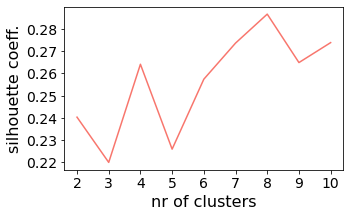

In [9]:
kmeans_kwargs = {
    'init': 'k-means++',
    'n_init': 10,
    'max_iter': 300, 
    'random_state': 42
}

silhouette_coeffs = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_attributes)
    score = silhouette_score(scaled_attributes, kmeans.labels_)
    silhouette_coeffs.append(score)
    
fig = plt.figure(figsize=(5, 3))
plt.plot(range(2, 11), silhouette_coeffs, color='#f8766d')
plt.xticks(range(2, 11), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('nr of clusters', fontsize=16)
plt.ylabel('silhouette coeff.', fontsize=16)
plt.show()

### k-means Clustering

Into 4 and 8 clusters.

Attention: cluster numbers reach from 0 to 3 (7).

In [31]:
k_list = [4, 8]
predictions = {}
basins_in_cluster = {}
for k in k_list:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs).fit(scaled_attributes)
    data =  kmeans.predict(scaled_df.values)
    
    predictions_df = pd.DataFrame(data=data, index=attributes_df.index.values)
    predictions_df.rename(columns = {0: 'cluster'}, inplace = True)
    predictions[k] = predictions_df
    
    basins_in_cluster[k] = {}
    print(f'with k={k} clusters:\n{predictions[k].cluster.value_counts()}')
    
    for cluster in range(k):
        basins_in_cluster[k][str(cluster)] = predictions_df.loc[predictions_df.cluster == cluster].index.values

with k=4 clusters:
0    253
3    133
1     70
2     60
Name: cluster, dtype: int64
with k=8 clusters:
1    192
5     65
2     61
7     55
0     54
6     47
3     28
4     14
Name: cluster, dtype: int64


In [16]:
# Cluster centers (mean attribute value per cluster) when building 8 clusters.
cluster_centers_df = pd.DataFrame(data=scaler.inverse_transform(kmeans.cluster_centers_), 
                                  columns=attributes_df.columns, 
                                  index=np.arange(1,9,1))
cluster_centers_df.index.rename('Cluster Nr.', inplace=True)
cluster_centers_df.style.format('{:.2f}')\
                    .apply(highlight_max)\
                    .apply(highlight_min)\
                    .set_table_styles([cell_hover])


,area_gages2,geol_permeability,soil_porosity,carb_rocks_frac,elev_mean,slope_mean,gvf_max,gvf_diff,lai_diff,lai_max,p_mean,pet_mean,aridity,high_prec_dur,low_prec_dur,high_prec_freq,low_prec_freq,frac_snow_daily,soil_depth_statsgo,soil_conductivity,max_water_content
Cluster Nr.,,,,,,,,,,,,,,,,,,,,,
1,596.66,-12.37,0.09,0.80,334.55,48.76,0.46,0.13,2.22,2.57,2.78,480.19,177.42,0.15,1.08,18.85,299.58,0.05,1.99,3.11,0.42
2,418.42,-14.60,0.10,0.06,487.78,130.99,0.62,0.19,4.03,4.54,3.26,478.38,149.05,0.16,0.97,21.02,282.10,0.10,1.98,5.39,0.43
3,307.48,-13.69,0.10,0.12,2641.79,285.61,0.32,0.05,1.14,1.45,2.04,475.98,244.33,0.14,1.02,20.60,280.77,0.38,1.85,6.16,0.45
4,534.08,-14.49,0.12,0.00,1118.19,294.76,0.62,0.08,1.49,3.18,3.29,478.59,151.41,0.23,1.79,22.18,287.08,0.10,1.99,6.03,0.47
5,371.90,-13.78,0.12,0.01,1085.13,264.46,0.31,0.06,0.68,1.18,1.21,481.29,408.74,0.20,2.72,16.35,331.65,0.01,1.68,4.94,0.43
6,767.42,-14.48,0.17,0.04,401.05,24.14,0.36,0.12,1.74,1.99,2.34,479.80,215.62,0.16,1.23,17.91,307.60,0.08,2.00,2.96,0.40
7,367.74,-13.46,0.12,0.00,840.35,352.01,0.68,0.11,2.41,4.07,5.29,477.74,92.19,0.19,1.07,20.91,231.59,0.10,1.96,7.13,0.52
8,610.97,-13.05,0.21,0.02,71.68,24.46,0.62,0.13,2.39,3.54,3.35,481.81,144.77,0.14,0.95,19.75,295.30,0.01,2.00,5.93,0.41


### Plotting results on map

In [28]:
# load HRU shape files

map_df = gpd.read_file('data\HUC_shapes\wbdhu2_fixed_geom\wbdhu2_fixed_geom.shp')
# hucs from 1..18 are CONUS, huc >18 is Alaska and islands
hucs = sorted(map_df.huc2.unique())[:-4]
map_df_sub = map_df.loc[map_df.huc2.isin(hucs)]

# load lat lon gauge data from Camels US dataset
loc_df = pd.read_csv('data/camels_attributes/camels_topo.txt', 
                     sep=';', 
                     header=0, 
                     dtype={'gauge_id': str})\
                    .set_index('gauge_id')

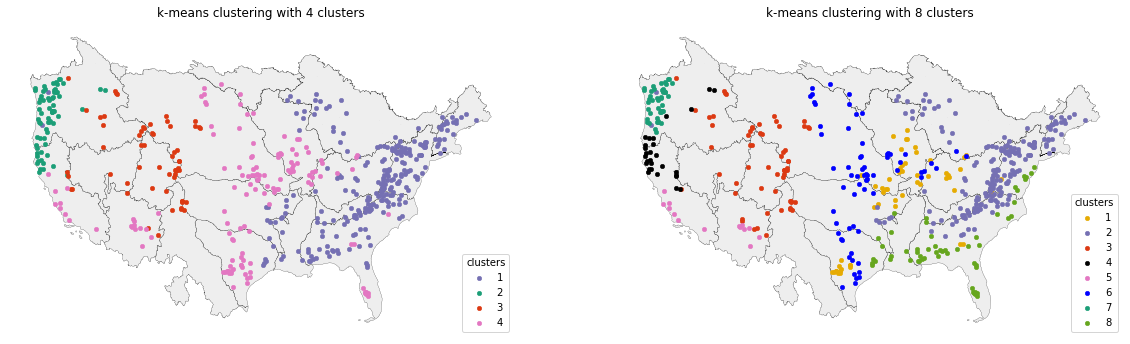

In [32]:
# to ensure same colors for clusters with similar geographic location as for clusters based on camels us
color_list_6 = ['#7570b3', '#1b9e77', '#DC3912', '#e377c2', '#1b9e77', '#7570b3', 'navy']
color_list_7 = ['#e6ab02', '#7570b3', '#DC3912', 'black', '#e377c2', 'blue', '#1b9e77', '#66a61e']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

for i, k in enumerate(k_list):
    if k==4: 
        color_list = color_list_6
    elif k==8:
        color_list = color_list_7

    map_df_sub.plot(ax=ax[i], facecolor='#eeeeee', edgecolor='black', linewidth=0.2)

    for cluster, basins in basins_in_cluster[k].items():
        data = {'lat': [], 'lon': [], 'color': []}

        data["lat"].append(loc_df.loc[loc_df.index.isin(basins), 'gauge_lat'][:])
        data["lon"].append(loc_df.loc[loc_df.index.isin(basins), 'gauge_lon'][:])
        data["color"].append(color_list[int(cluster)])
        
        label = int(cluster) + 1
        points = ax[i].scatter(x=data["lon"],
                                 y=data["lat"],
                                 c=data["color"],
                                 s=20, 
                                 zorder=2,
                                 linewidth=0.5,
                                 label = str(label))
    ax[i].axis(False)
    ax[i].set_title(f'k-means clustering with {k} clusters')
    ax[i].legend(loc='lower right', title='clusters')
plt.savefig('plots/k-means_maps_hydromt.png')
plt.show()


### Assign Meuse catchment to clusters 

In [23]:
# Load europe catchments attributes
attributes_df_eu = pd.read_csv('data/hydromt_attributes/ubasin_europe.csv', header=0, dtype={'hru_id': str})
attributes_df_eu = attributes_df_eu.rename(columns= {'hru_id': 'basin_id', 
                                                           'area_km2': 'area_gages2', 
                                                           'soil_thickness': 'soil_depth_statsgo',
                                                           'ksatver_logmean': 'soil_conductivity',
                                                           'theta_s': 'max_water_content'})
attributes_df_eu.index = attributes_df_eu.basin_id
attributes_df_eu = attributes_df_eu.drop(columns='basin_id')
attributes_df_eu = attributes_df_eu[attributes_df_eu.index.str.startswith('meuse')]
# attributes_df_eu

In [26]:
# scale attributes with same scaler as for camels us basins
scaled_attributes_eu = scaler.transform(attributes_df_eu.values)
scaled_df_eu = pd.DataFrame(data=scaled_attributes_eu, columns=attributes_df_eu.columns, index=attributes_df_eu.index)

basins_eu = attributes_df_eu.index.tolist()

# scaled_df_eu

In [27]:
# assign to cluster

data_eu =  kmeans.predict(scaled_df_eu.values)

predictions_df_eu = pd.DataFrame(data=data_eu, index=attributes_df_eu.index.values)
predictions_df_eu.rename(columns = {0: 'cluster'}, inplace = True)

# basins_in_cluster[k] = {}
print(f'with k={k} clusters:\n{predictions_df_eu.cluster.value_counts()}')

for cluster in range(k):
    basins_in_cluster[k][str(cluster)] = predictions_df_eu.loc[predictions_df_eu.cluster == cluster].index.values

with k=8 clusters:
7    7
Name: cluster, dtype: int64
